# Setup

Clear previous Brian2 runs

In [9]:
from brian2 import *
start_scope()

Parameters

In [10]:
N = 1000
sim_duration = 100 * second
tau_m = 10 * ms
tau_pre = 20 * ms
tau_post = tau_pre
refract_period = 5 * ms
E_e = 0 * mV
V_thr = -54 * mV
V_reset = -60 * mV
E_l = -74 * mV
tau_e = 5 * ms
F = 15 * Hz
gmax = 0.01
dApre = 0.01
dApost = -dApre * tau_pre / tau_post * 1.05
dApost *= gmax
dApre *= gmax

record_from = [0, 10, 110, 120]

eqs_neurons = '''
dv/dt = (ge * (E_e - v) + E_l - v) / tau_m : volt
dge/dt = -ge / tau_e : 1
'''

poisson_input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v > V_thr', reset='v = V_reset',
                      refractory=refract_period, method='euler')
S = Synapses(poisson_input, neurons,
             '''w : 1
                dApre/dt = -Apre / tau_pre : 1 (event-driven)
                dApost/dt = -Apost / tau_post : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect()
S.w = 'rand() * gmax'
spike_mon = SpikeMonitor(poisson_input)
state_mon = StateMonitor(S, 'w', record=record_from)

# Run

In [11]:
run(sim_duration, report='text')

Starting simulation at t=0. s for a duration of 100. s
4.5283 s (4%) simulated in 10s, estimated 3m 31s remaining.
9.5451 s (9%) simulated in 20s, estimated 3m 10s remaining.
14.9349 s (14%) simulated in 30s, estimated 2m 51s remaining.
20.3839 s (20%) simulated in 40s, estimated 2m 36s remaining.
25.7893 s (25%) simulated in 50s, estimated 2m 24s remaining.
31.2575 s (31%) simulated in 1m 0s, estimated 2m 12s remaining.
36.7288 s (36%) simulated in 1m 10s, estimated 2m 1s remaining.
42.1613 s (42%) simulated in 1m 20s, estimated 1m 50s remaining.
47.6823 s (47%) simulated in 1m 30s, estimated 1m 39s remaining.
53.2028 s (53%) simulated in 1m 40s, estimated 1m 28s remaining.
58.6598 s (58%) simulated in 1m 50s, estimated 1m 18s remaining.
64.1162 s (64%) simulated in 2m 0s, estimated 1m 7s remaining.
69.5362 s (69%) simulated in 2m 10s, estimated 57s remaining.
74.9583 s (74%) simulated in 2m 20s, estimated 47s remaining.
80.3927 s (80%) simulated in 2m 30s, estimated 37s remaining.
85

# Analyze

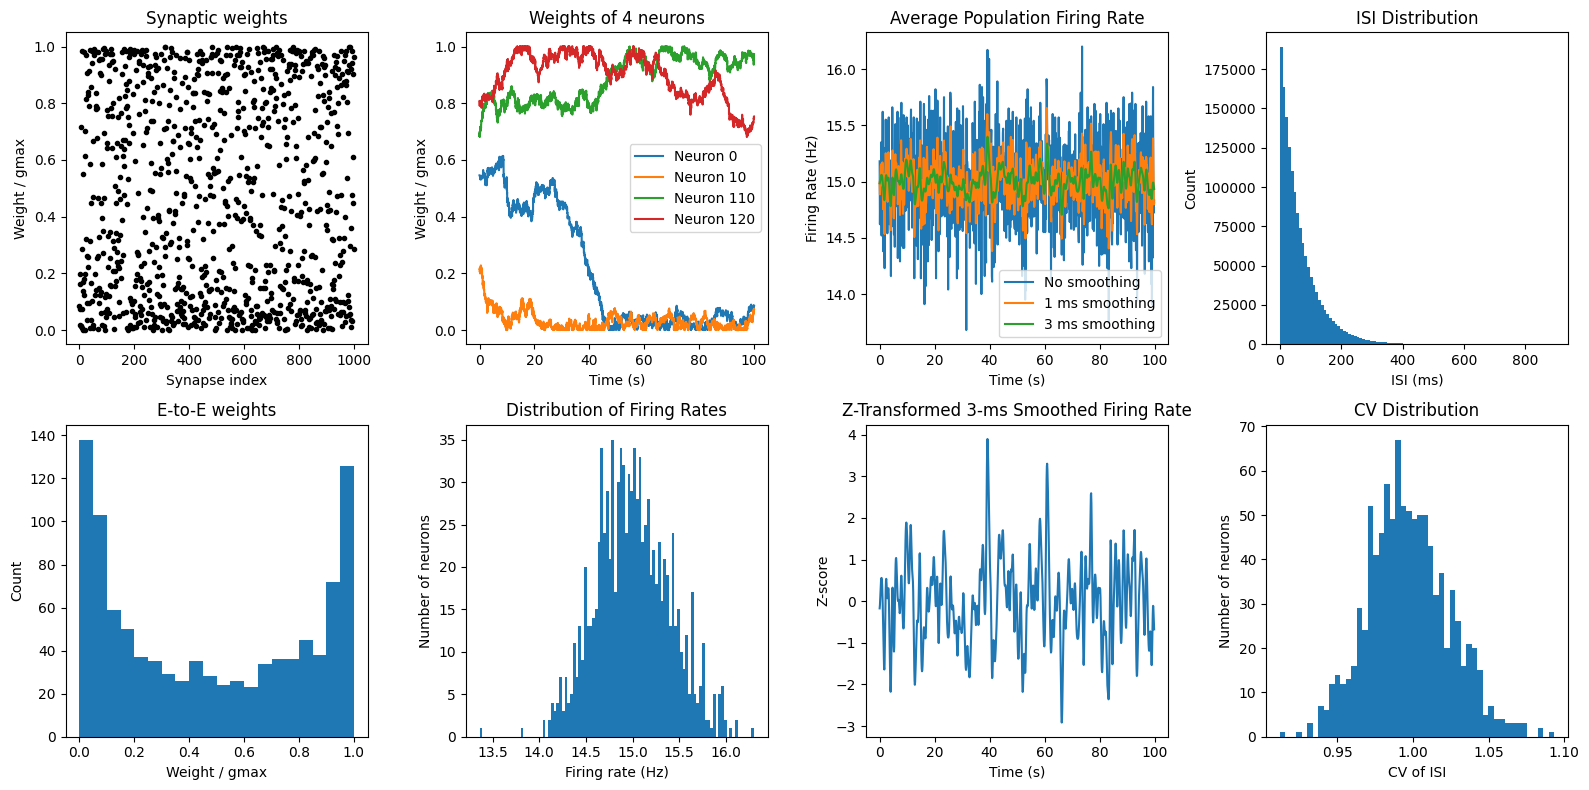

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

# Synaptic weights figures
ax[0, 0].plot(S.w / gmax, '.k')
ax[0, 0].set_xlabel('Synapse index')
ax[0, 0].set_ylabel('Weight / gmax')
ax[0, 0].set_title('Synaptic weights')

ax[1, 0].hist(S.w / gmax, 20)
ax[1, 0].set_xlabel('Weight / gmax')
ax[1, 0].set_ylabel('Count')
ax[1, 0].set_title('E-to-E weights')

ax[0, 1].plot(state_mon.t/second, state_mon.w.T/gmax, label=[f'Neuron {i}' for i in record_from])
ax[0, 1].set_xlabel('Time (s)')
ax[0, 1].set_ylabel('Weight / gmax')
ax[0, 1].set_title(f'Weights of {len(record_from)} neurons')
ax[0, 1].legend(loc='best')

# Population firing rate
spike_counts = np.bincount(spike_mon.i, minlength=N)
firing_rate = spike_counts / (sim_duration / second)
ax[1, 1].hist(firing_rate, bins=100)
ax[1, 1].set_xlabel('Firing rate (Hz)')
ax[1, 1].set_ylabel('Number of neurons')
ax[1, 1].set_title('Distribution of Firing Rates')

from scipy.ndimage import gaussian_filter1d
spike_times = np.array(spike_mon.t / second)
bin_width = 100 * ms
bins = np.arange(0, sim_duration / second, bin_width / second)
spike_counts, _ = np.histogram(spike_times, bins)
avg_firing_rate = spike_counts / (N * bin_width)
smoothed_1 = gaussian_filter1d(avg_firing_rate, sigma=1)
smoothed_3 = gaussian_filter1d(avg_firing_rate, sigma=3)
time_bins = bins[:-1] + bin_width / (2 * second)

ax[0, 2].plot(time_bins, avg_firing_rate, label='No smoothing')
ax[0, 2].plot(time_bins, smoothed_1, label='1 ms smoothing')
ax[0, 2].plot(time_bins, smoothed_3, label='3 ms smoothing')
ax[0, 2].set_xlabel('Time (s)')
ax[0, 2].set_ylabel('Firing Rate (Hz)')
ax[0, 2].set_title('Average Population Firing Rate')
ax[0, 2].legend(loc='lower right')

z_rate_E = (lambda x: (x - np.mean(x)) / np.std(x))(smoothed_3)
ax[1, 2].plot(time_bins, z_rate_E)
ax[1, 2].set_xlabel('Time (s)')
ax[1, 2].set_ylabel('Z-score')
ax[1, 2].set_title('Z-Transformed 3-ms Smoothed Firing Rate')

# ISI and CVs
ISIs = []
spike_train_dict = spike_mon.spike_trains()
for i in range(N):
    times = spike_train_dict[i]
    if len(times) > 1:
        isi = np.diff(times)
        ISIs.append(isi)
all_ISIs = np.hstack(ISIs)
CVs = [np.std(isi)/np.mean(isi) for isi in ISIs if len(isi) > 1]

ax[0, 3].hist(all_ISIs * second / ms, bins=100)
ax[0, 3].set_xlabel('ISI (ms)')
ax[0, 3].set_ylabel('Count')
ax[0, 3].set_title('ISI Distribution')

ax[1, 3].hist(CVs, bins=50)
ax[1, 3].set_xlabel('CV of ISI')
ax[1, 3].set_ylabel('Number of neurons')
ax[1, 3].set_title('CV Distribution')

fig.tight_layout()